# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from numba import jit

# Parameters

In [3]:
nx = 51 # number of x-control volumes
ny = 51 # number of y-control volumes
Γ  = 1.0 # diffusion coefficient
source = 0.0 # source term (for Poisson Equation)

x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0

# Grid generation

In [4]:
x = np.zeros([nx+2])  # internal nodes plus 1 boundary node on each side
dx = (x_max-x_min)/nx # cell-size in x-direction
dy = (y_max-y_min)/ny # cell-size in y-direcyion

x[0] = x_min
x[-1] = x_max
x[1:-1] = np.arange(x_min+dx/2,x_max,dx)

#print(x)

y = np.copy(x)

In [5]:
X,Y = np.meshgrid(x,y)
#plt.scatter(X[::2],Y[::2])
#X[:,1]

# Exact Solution

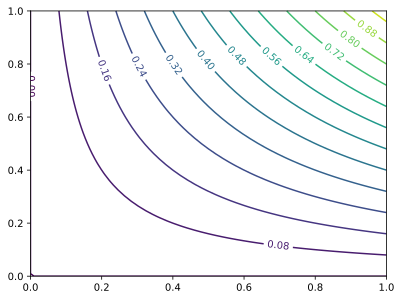

In [6]:
ϕ_exact = X*Y
cs = plt.contour(X,Y,ϕ_exact,levels=15)
plt.clabel(cs,inline=True,fontsize=10);

# Boundary Condition Values

In [7]:
bc_val_left = np.zeros_like(y)
bc_val_right = np.copy(y)
bc_val_bottom = np.zeros_like(x)
bc_val_top = np.copy(x)

# Assemble Coefficient Matrices

In [8]:
# Calculate coefficient for all the internal grid points
Ap = np.zeros([ny+2,nx+2])
Ae = np.ones([ny+2,nx+2])*(Γ*dy/dx)
Aw = np.ones([ny+2,nx+2])*(Γ*dy/dx)
An = np.ones([ny+2,nx+2])*(Γ*dx/dy)
As = np.ones([ny+2,nx+2])*(Γ*dx/dy)

Su = np.zeros([ny+2,nx+2])
Sp = np.zeros([ny+2,nx+2])

# Apply boundary conditions
# West boundary
Aw[1:-1,1] = 0.0
Su[1:-1,1] = Su[1:-1,1] + 2*Γ*dy/dx*bc_val_left[1:-1]
Sp[1:-1,1] = Sp[1:-1,1] - 2*Γ*dy/dx

# East boundary
Ae[1:-1,-2] = 0.0
Su[1:-1,-2] = Su[1:-1,-2] + 2*Γ*dy/dx*bc_val_right[1:-1]
Sp[1:-1,-2] = Sp[1:-1,-2] - 2*Γ*dy/dx

# North Boundary
An[-2,1:-1] = 0.0 
Su[-2,1:-1] = Su[-2,1:-1] + 2*Γ*dx/dy*bc_val_top[1:-1]
Sp[-2,1:-1] = Sp[-2,1:-1] - 2*Γ*dx/dy

# South boundary
As[1,1:-1] = 0.0
Su[1,1:-1] = Su[1,1:-1] + 2*Γ*dx/dy*bc_val_bottom[1:-1]
Sp[1,1:-1] = Sp[1,1:-1] - 2*Γ*dx/dy

Ap = Ae + Aw + An + As - Sp

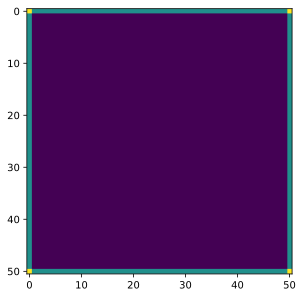

In [9]:
plt.imshow(Ap[1:-1,1:-1])
#Ap[1:-1,1:-1]

# Jacobi Relaxation

## Initialize arrays

In [22]:
ϕ_init = np.zeros([ny+2,nx+2])
# Apply boundary conditions
ϕ_init[:,0] = bc_val_left # west boundary
ϕ_init[:,-1] = bc_val_right # east boundary
ϕ_init[0,:] = bc_val_bottom # south boundary
ϕ_init[-1,:] = bc_val_top # north boundary

In [27]:
@jit(nopython=True)
def Jacobi_relaxation(ϕ,Ap,Ae,Aw,An,As,Su,l2_target,max_iter):
    J,I = ϕ.shape
    error = 1.0
    num_iter = 0
    
    while error > l2_target and num_iter <= max_iter:
        ϕ_old = np.copy(ϕ)
        # Jacobi Iterations
        for j in range(1,J-1):
            for i in range(1,I-1):
                ϕ[j,i] = (Aw[j,i]*ϕ_old[j,i-1]+Ae[j,i]*ϕ_old[j,i+1]+An[j,i]*ϕ_old[j+1,i]+As[j,i]*ϕ_old[j-1,i]+Su[j,i])/Ap[j,i]
                
        for j in range(J):
            for i in range(I):
                error = error + (ϕ[j,i]-ϕ_exact[j,i])**2.0
                
        error = np.sqrt(error/(J*I))
        num_iter += 1
        #print(f"Iteration {num_iter}, error = {error}")
    return ϕ, error, num_iter

**Jacobi Solution**

In [28]:
# Jacobi solution
tol = 1e-4
max_iter = 10000
ϕ_Jacobi, error_Jacobi, num_iterations = Jacobi_relaxation(ϕ_init,Ap,Ae,Aw,An,As,Su,tol,max_iter)

In [29]:
error_Jacobi

0.00035599857600569605

In [30]:
num_iterations

10001

<a list of 11 text.Text objects>

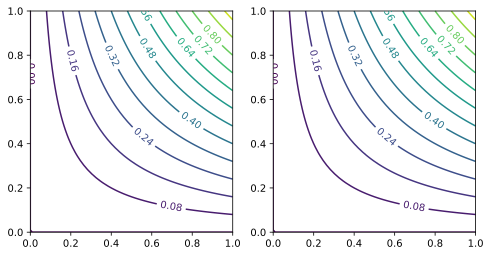

In [32]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
cs1 = ax[0].contour(X,Y,ϕ_Jacobi,levels=15)
cs2 = ax[1].contour(X,Y,ϕ_exact,levels=15)
ax[0].clabel(cs1,inline=True,fontsize=10)
ax[1].clabel(cs2,inline=True,fontsize=10)